# Методы сжатия и обработки видео

Полезные ссылки:
* [Telegram-чат](https://t.me/compression2020)
* [Документация pybind](https://pybind11.readthedocs.io/en/master/)

Понадобится для работы:
* Pybind11: `conda install -c conda-forge pybind11` (если у вас [Anaconda](www.anaconda.com) или `pip install pybind11`)
* Opencv2: `conda install -c conda-forge opencv` или `pip install opencv-python`) 
* C++ компилятор  

*Если у вас не заработало что-то, смело пишите в чатик курса*

## Задание 3. Motion Estimation ##

Шаблон для выполнения задания состоит из нескольких частей

1. Библиотека ME на C/C++, компилируемая для использования в python-коде. В основном писать код вам придётся именно в библиотеке. Чтобы скомпилировать библиотеку, запустите команду `python3 setup.py build_ext -i` в  корне папки с заданием. *Замечание. Это библиотека компилируется под C++, но внутри вам ничего не мешает писать код на чистом C.*
2. Ipython notebook для тестирования библиотеки. Используйте этот код для оценки качества работы программы и её улучшения.

### 1. Основная часть ###

Оценка качества работы алгоритма будет производиться следующим образом: на основе поля ME между двумя кадрами будет построен восстановленный кадр. Для оценивания качества будет использоваться PSNR между восстановленным и исходным кадром:

<img src="images/me_example.png">

<img src="images/how_it_works.png">

Кроме того, ещё одним параметром работы будет являться **скорость работы**.

In [1]:
# Импортируем нужные библиотеки
import cv2
import numpy as np

import time
import itertools
from tqdm.notebook import tqdm
from copy import copy

import matplotlib.pyplot as plt
import seaborn as sns
import skimage
import importlib
%matplotlib inline

In [2]:
#Библиотека для чтения видео
class VideoReader:
    def __init__(self, path):
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
        print("Video height and width : {}x{}".format(self.height, self.width))
    
    def __iter__(self):
        while(self.cap.isOpened()):
            ret, frame = self.cap.read()
            if ret == False:
                break
            yield frame
    
    def height(self):
        return self.heigth
    
    def width(self):
        return self.width
    
    def __del__(self):
        self.cap.release()

def generate_pair_frames_gray(video):
    prev_frame = None
    for frame in video:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        if prev_frame is None:
            prev_frame = frame
        else:
            yield prev_frame, frame
            prev_frame = frame

In [3]:
def draw_vector(crop, vector, h, w):
    if not vector.is_splitted():
        h_vector = vector.getHeight() + 8
        w_vector = vector.getWidth() + 8
        
        h += 8
        w += 8
        cv2.arrowedLine(crop, (w, h), (w_vector, h_vector), (0, 0, 0), thickness=1)
    else:
        h_offset = [0, 0, 8, 8]
        w_offset = [0, 8, 8, 0]
        vectors = vector.getSubvectors()
        for i in range(4):
            new_h = vectors[i].getHeight()
            new_w = vectors[i].getWidth()
            cv2.arrowedLine(crop, (w + w_offset[i] + 4, h + 4 + h_offset[i]), (new_w + 4, new_h + 4), (0, 0, 0), thickness=1)
    return crop

In [4]:
def draw_vectors(frame, vector_field):
    H, W = frame.shape
    h_range = range(0, H, 16)
    w_range = range(0, W, 16)
    true_range = itertools.product(h_range, w_range)
    for index, (h, w) in enumerate(true_range):
        frame = draw_vector(frame, vector_field[index], h, w)
    return frame

In [5]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Простая функция для тестирования ME.
def test_me(source_video, me, return_frames=False, result_path=None, should_draw_vectors=False):
    ssim = []
    psnr = []
    speed = []
    previous_frames = []
    compensated_frames = []
    source_frames = []
    vectorized_frames = []
    vector_fields = []
    out_video = None
    if result_path is not None:
        out_video = cv2.VideoWriter(
            result_path,
            cv2.VideoWriter_fourcc(*'MP4V'),
            10,
            (source_video.width, source_video.height * 2)
        )
     
    pbar = tqdm(generate_pair_frames_gray(source_video))
    for prev_frame, frame in pbar:
        
        start = time.time()
        vector_field = me.Estimate(prev_frame, frame)
        end = time.time()
        
        speed.append((end - start) * 1000)
        compensated_frame = me.Remap(prev_frame) # Скомпенсированный кадр лежит тут. Полезно для дебага его отсюда доставать и рассматривать.
        ssim.append(structural_similarity(frame, compensated_frame, multichannel=False))
        psnr.append(peak_signal_noise_ratio(frame, compensated_frame))
        if return_frames:
            compensated_frames.append(compensated_frame)
            source_frames.append(frame)
        pbar.set_description('PSNR: {:.2f}; Time(ms): {:.2f}; SSIM: {:.2f}.'.format(np.mean(psnr), np.mean(speed), np.mean(ssim)))
        
        if out_video is not None:
            out_video.write(cv2.cvtColor(np.vstack([frame, compensated_frame]), cv2.COLOR_GRAY2BGR))
    if out_video is not None:
        out_video.release()
        
    return {
        'ssim': ssim,
        'psnr': psnr,
        'speed': speed,
        'compensated_frames': compensated_frames,
        'source_frames': source_frames
    }

## Ваше решение

- В качестве решения вы должны прикрепить класс ниже.
- Менять прототипы для init и Estimate **нельзя**.
- **Должен** быть возможен вызов вида `test_me(video, me)`.

In [6]:
# GRADED CELL: MotionEstimator

class MotionEstimator:
    def __init__(self, width, height, quality, halfpixel):
        import me_estimator
        
        self.width = width
        self.height = height
        self.quality = quality
        self.halfpixel = halfpixel

        self.me = me_estimator.MotionEstimator(self.width, self.height, self.quality, self.halfpixel)
    def Estimate(self, frame, prev_frame):
        return self.me.Estimate(frame, prev_frame)
    
    def Remap(self, prev_frame):
        return self.me.Remap(prev_frame)
    
    def method_name(self, method):
        self.methods = {
            0 : "Brute force",
            1 : "Cross search",
            2 : "Orthonormal search",
            3 : "3DRS",
            4 : "Three step search",
            5 : "Diamond search",
            6 : "Hexagon search"
        }
        return self.methods[method]
    def set_SearchMethod(self, method):
        """ 
        Input : method, pass
                0 for MODE::BruteForce
                1 for MODE::CrossSearch
                2 for MODE::OthonormalSearch
                3 for MODE::_3DRS (not implemented yet)
                4 for MODE::ThreeStepSearch
                5 for MODE::DiamondSearch
                6 for MODE::HexagonSearch
        """
        self.me.set_SearchMethod(self.get_cpp_input(method))
        
    def set_CrossSearch_ErrorThreshold(self, threshold):
        self.me.set_CrossSearch_ErrorThreshold(self.get_cpp_input(threshold))
        
    def set_CrossSearch_Side(self, side):
        self.me.set_CrossSearch_Side(self.get_cpp_input(side))
        
    def get_cpp_input(self, inp):
        return np.array([inp], dtype=np.int32)

**Если вы делали какие-то изменения, то не забудьте перезагрузить модуль. Для этого нажмите Kernel->Restart**

Чтобы проверить, как работет библиотека, давайте проверим его на одной последовательности на самом хорошем качестве.  
*То, что Ваше ME будет по качеству работать хуже полного перебора - это норма. Ваша задача - достаточно сильно ускорить ME, он должен работать ориентировочно за 5-10 мс на кадр. Ориентировочная точка - одно из самых лучших решений прошлого года на среднем ноутбуке показало **5.06ms и 35.1 psnr** на качестве 100.*

In [15]:
import pandas as pd

def test_all_me(video_paths=['waterfall.mp4', 'source.avi', 'foreman.mp4'], qualities=[100, 80, 60, 40, 20], halfpixels=[False, True]):
    result = []
    for video_path in video_paths:
        for halfpixel in halfpixels:
            for quality in qualities:
                video = VideoReader(video_path)
                me = MotionEstimator(video.width, video.height, quality, halfpixel)
                metrics = test_me(video, me)
                result.append(
                    {
                        'video': video_path,
                        'halfpixel': halfpixel,
                        'quality': quality,
                        **{
                            key: np.mean(metrics[key])
                            for key in ['psnr', 'speed', 'ssim']
                        }
                    }
                )
    return pd.DataFrame(result)

In [16]:
result_all = test_all_me(
    video_paths=['video/Susie.avi', 'video/foreman.mp4'],
    qualities=[0],
    halfpixels=[False, True]
)

Video height and width : 288x352



Video height and width : 288x352



Video height and width : 288x352



Video height and width : 288x352


In [17]:
result_all

,video,halfpixel,quality,psnr,speed,ssim
0,video/Susie.avi,False,0,34.760252,2.798497,0.926769
1,video/Susie.avi,True,0,36.603725,9.134780,0.946359
2,video/foreman.mp4,False,0,31.280054,3.374132,0.923779
3,video/foreman.mp4,True,0,33.049917,13.282851,0.941060


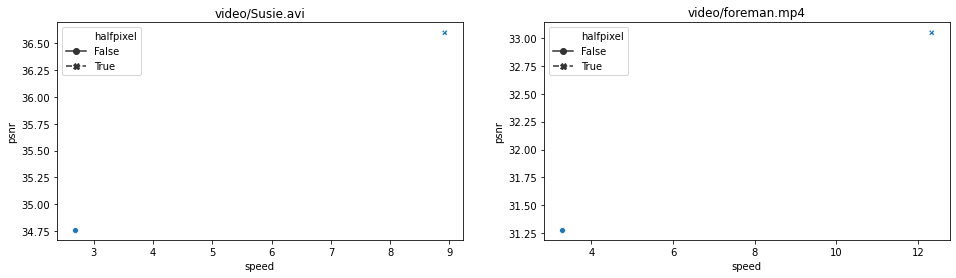

In [14]:
fig, axes = plt.subplots(1, len(result_all['video'].unique()), figsize=(16, 4))
if len(result_all['video'].unique()) == 1:
    axes = [axes]
for ax, video in zip(axes, result_all['video'].unique()):
    ax.set_title("{}".format(video))
    sns.lineplot(x='speed', y='psnr', style='halfpixel', markers=True, data=result_all[result_all.video == video], ax=ax)

## 2. Красивый вид кривых скорость/качество ##

*Это бонусное задание, за него вы получите баллы независимо от результатов в конкурсе*

Что хочется увидеть: у ME есть два ключевых параметра, определяющих его "хорошесть" - это скорость работы и качество сопоставления. Очевидно, можно написать метод, который делает полный перебор - он будет лучшим по качеству, но медленным, или наоборот - ничего не сопоставляем: ужасное качество, но замечательная скорость, Хочется, чтобы ваш алгоритм позволял варьировать скорость и качество и не уходил в такие крайности. Ниже пример кривых, которые были в прошлом году - хочется, чтобы форма кривых была как можно ближе к синей c треугольниками:

<img src="images/curves.png">

## 3. Опиши что было сделано ##

### 0. Обзор

В приницпе уже написан выше, но да - 

Лучшее решение для данной задачи по качеству - brute-force. 


Поэтому нужно придумать умное сокращение, которое позволит очень сильно выиграть во времени, при этом не потеряв в качестве.

## I. Проверены несколько методов

* Brute-force
* Cross-search + Quadtree Partition 
* Orthonormal-search
* Diamond-search + Quadtree Partition
* Hexagon-search + Quadtree Partition 

### Disclaimer 
Вся последующая информация относится к тестовому видео Susie.avi

### Brute-force

Удалось довести до 35.5 PSNR и 20ms, без Quadtree

### Cross-search

Один из неплохих шаблонных поисков, был первым после брутфорса, но не очень точный.

### Orthonormal-search

Работает хуже всех, видимо все же проверять одну степень свободы за шаг не очень хорошая идея

### Three-step-search

Лучше Cross-search, однако, все равно не обладающий достаточной точностью (исходя из данных, полученных в результате эксперимента).

Из плюсов - константное количество операций сравнения (т.е. в теории константное время сходимости), в отличии от Diamond-Search, который может разойтись, но на практике он всегда сходится (вспоминаем Adam :D).

## Diamond-search

Показывает самые лучшие результаты среди всех исследованных методов (кроме брут-форса, конечно), 
главным преимуществом этого метода является то, что шаг метода составляет всего-лишь два пикселя, а в конце делается уточнение, итого точность составляет +- 0.5 от положения true motion вектора.

К тому же, чисто статистически было показано (в статьях), что "очень хороший" motion вектор чаще всего лежит не дальше, чем в семи пикселях от reference point, что обеспечивает быструю сходимость метода (avg. 16 сравнений на блок)

Для улучшения качества была принята попытка реализации квадродерева (aka partition блока 16х16 на 8х8), что в свою очередь неплохо бустануло метод по качеству, не ухудшив скорость (ибо в Susie очень много блоков статичны, из-за чего partition происходит редко).

Стоит отметить, что иногда получавшиеся 4 блока 8x8 имели в сумме ошибку больше, чем прежде найденная у 16x16.

### Hexagon-search

Адаптация Diamond-search с небольшой потерей качества и серьезными увеличениями в скорости (как заявлялось в статье о нем), но увы, потери в качестве мне показались существенными (> 0.4 PSNR), хотя буст в скорости составил где-то 15%

## I.1 Общее

### Early-stopping

Кроме того, для ускорения поиска была применена техника early-stopping, - выходим из поиска, если изначальный блок кажется нам неподвижным. Это позволяет сократить количество проверок с avg = 16 до одной.

Так же реализован выход внутри поиска при достижении определенного порого, с которого мы считаем блок "хорошим"

Так же при подсчете метрики реализована возможность раннего выхода, если текущая ошибка превышает найденную ранее.

### 3DRS

Вектора-кандидаты используются, как часть тактики early-stopping перед поиском с помощью Diamond-Search, эксперементально кажется, что с этой фичей алгоритм работает чуть-чуть (< 10%) быстрее.

### Мысли для будущих исследований

* До конца разобраться с 3DRS и получить нормальных кандидатов
* Увеличить Quadtree-depth
* Использование блоков разных форм (не только квадратных, но и прямоугольных, например), как описано в H264ом стандарте 

## P.S.

Графики в данных момент актуальны (для примера), но функция test_method не работает, потому что эстиматор был изменен в сторону производительности (была убрана возможность выбирать метод)

In [15]:
def test_method(method, draw_vectors=True, quality=100, halfpixel=False):
    video = VideoReader('video/foreman.mp4')
    me = MotionEstimator(video.width, video.height, quality, halfpixel)
    me.set_SearchMethod(method)
    plt.figure(figsize=(12, 6))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    result = test_me(video, me, True, 'result_{}.mp4'.format(me.method_name(method)), should_draw_vectors=draw_vectors) 
    ax1.plot(result['ssim'])
    ax1.set_title('SSIM: {}'.format(np.mean(result['ssim'])))
    ax2.plot(result['psnr'])
    ax2.set_title('PSNR: {}'.format(np.mean(result['psnr'])))
    ax3.plot(result['speed'])
    ax3.set_title('Time: {}'.format(np.mean(result['speed'])));
    fig.suptitle("Method : {}, quality : {}, halfpixel : {}".format(me.method_name(method), quality, halfpixel), fontsize=14)
    return result

Video height and width : 288x352


<Figure size 864x432 with 0 Axes>

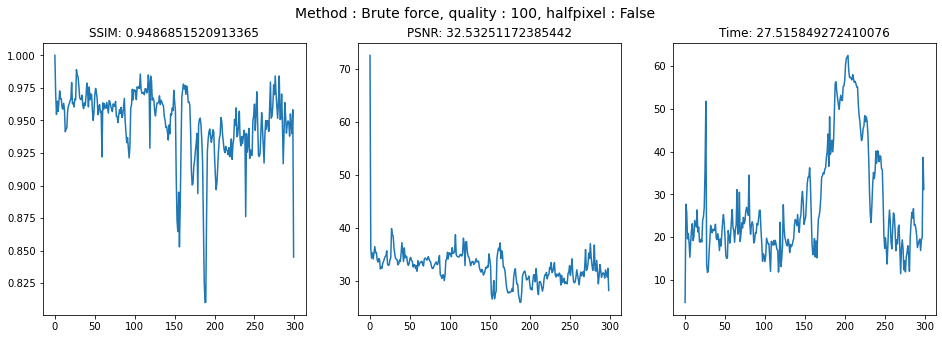

In [16]:
# Brute-force
# Quality : 35.446, time : 23.14ms time (Susie)
result_BruteForce = test_method(0, draw_vectors=True, quality=100, halfpixel=False)

Video height and width : 288x352


<Figure size 864x432 with 0 Axes>

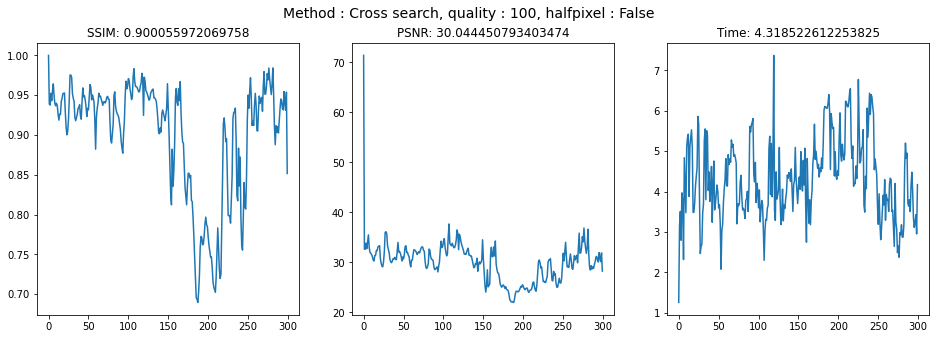

In [17]:
# Cross-search
# Quality : 33.37 PSNR, 3.064ms time
result_CrossSearch = test_method(1, draw_vectors=True)

Video height and width : 288x352


<Figure size 864x432 with 0 Axes>

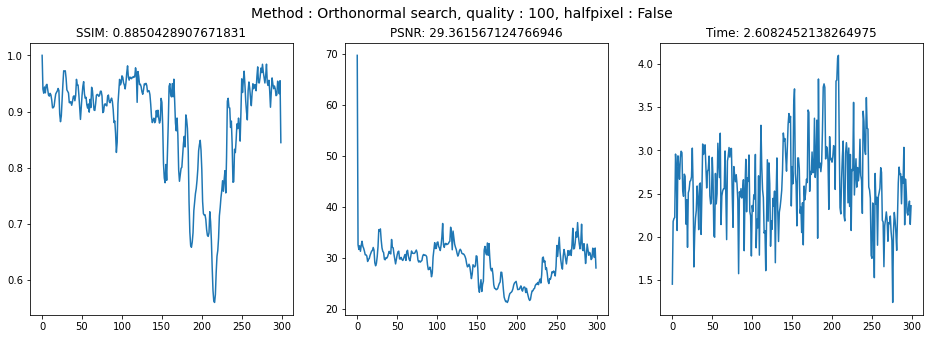

In [18]:
# Orthonormal-search
# Best results : 32.49, 1.77ms time
result_OrthonormalSearch = test_method(2, draw_vectors=True)

In [19]:
# 3DRS
# result_3DRS = test_method(3)

Video height and width : 288x352


<Figure size 864x432 with 0 Axes>

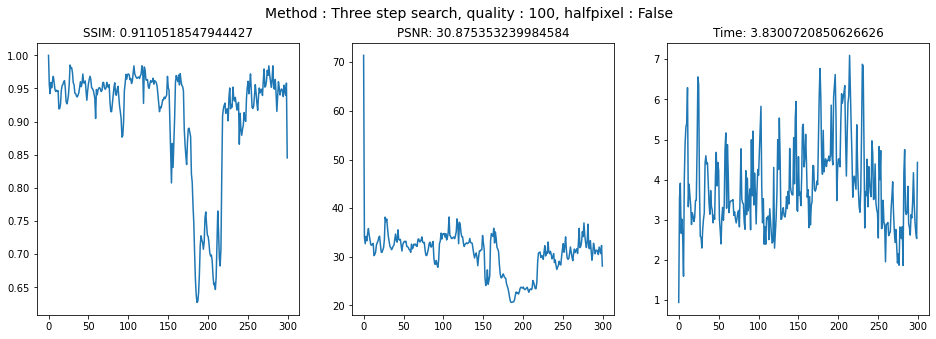

In [20]:
# Three step search

# Quality : 34.263 PSNR, 2.363ms time
result_ThreeStepSearch = test_method(4, draw_vectors=True)

Video height and width : 288x352



CPU times: user 10.6 s, sys: 2.76 s, total: 13.3 s
Wall time: 7.14 s


<Figure size 864x432 with 0 Axes>

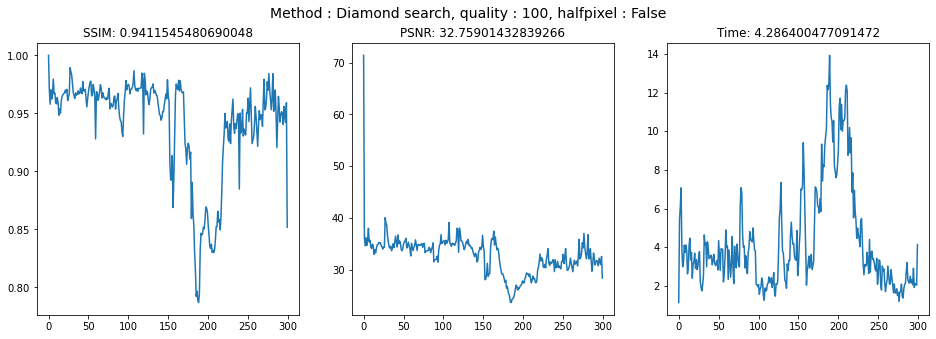

In [33]:
%%time
# Diamond Search
# Susie : 
# Quality : 35.34 PSNR, 3.07ms time, quality = 100, halfpixel = false
result_DiamondSearch = test_method(5, draw_vectors=True, quality=100, halfpixel=False)

Video height and width : 288x352


<Figure size 864x432 with 0 Axes>

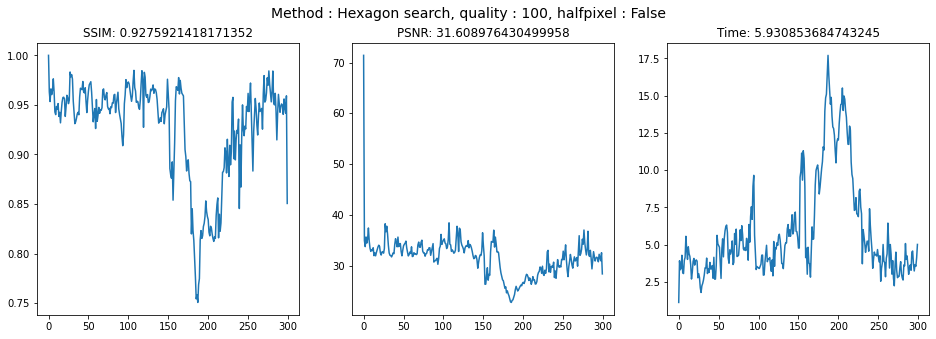

In [34]:
result_HexagonSearch = test_method(6, draw_vectors=True)

## II. Построение различных метрик

Графики, увы, вам строить нельзя, но я могу рассказать, какие метрики здесь снимались и что конкретно помогло : 

### show_frame():

Эта функция позволила отдебажить квадродерево, на ней впервые появились векторы.

### compare_two_methods():

Одна из самых полезных здесь функций. Она позволяет сравнивать быстрый алгоритмом с брутфорсом и смотреть, куда направлены векторы у обоих методов (а ведь мы знаем, что у брутфорса чаще всего направлены векторы куда надо)

Эта функция и подтолкнула меня использовать 3DRS, потому что в тестовом видео ```foreman.mp4``` было очень отчетливо видно, что Diamond-search серьзно ошибается в местах с горизонтальным движением (на кадрах, где буквально все векторы, предсказанные брутфорсом, направлены горизонтально так ещё и в одну сторону, вправо)

### draw_block_error():

Простая функция, позволившая поглядеть на ошибки у различных блоков с течением времени.

С помощью неё был подобран порог ```_error_threshold``` в эстиматоре для разного качества

### compare_psnr():

Тоже очень полезная функция, позволившая быстро находить кадры, на которых алгоритм отработал много хуже брут-форс.

Так, например, был найден кадр 180 в ```foreman.mp4```, упомянутый выше (с горизонтальным движением).

In [35]:
def show_pair_frames(compensated_frame, prev_frame, vectorized_frame, frame, psnr_value, method_name):
    fig = plt.figure(figsize=(24, 6))
    plt.suptitle('Значение PSNR: {:.4f}, метод : {}'.format(psnr_value, method_name), fontsize=24)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(prev_frame, cmap='gray')
    ax.set_title("Предыдущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(vectorized_frame, cmap='gray')
    ax.set_title("Кадр с векторами", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(frame, cmap='gray')
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

In [36]:
def method_name(method):
    methods = {
        0 : "Brute force",
        1 : "Cross search",
        2 : "Orthonormal search",
        3 : "3DRS",
        4 : "Three step search",
        5 : "Diamond search",
        6 : "Hexagon search"
    }
    return methods[method]

In [37]:
def get_result(method):
    if method == 0:
        result = result_BruteForce
    elif method == 1:
        result = result_CrossSearch
    elif method == 2:
        result = result_OrthonormalSearch
    elif method == 3:
        result = result_3DRS
    elif method == 4:
        result = result_ThreeStepSearch
    elif method == 5:
        result = result_DiamondSearch
    elif method == 6:
        result = result_HexagonSearch
    return result

def show_frame(frame_idx=0, method=0):
    result = get_result(method)
        
    show_pair_frames(
        result['compensated_frames'][frame_idx],
        result['previous_frames'][frame_idx],
        result['vectorized_frames'][frame_idx],
        result['source_frames'][frame_idx],
        result['psnr'][frame_idx],
        method_name(method)
    )

In [38]:
def comape_two_methods(frame=0, first_method=0, second_method=0):
    result_first = get_result(first_method)
    result_second = get_result(second_method)
    
    fig = plt.figure(figsize=(12, 14))
    plt.suptitle('Разница в PSNR: {:.4f}'.format(abs(result_first['psnr'][frame] - \
                                                             result_second['psnr'][frame])), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(result_first['compensated_frames'][frame], cmap='gray')
    ax.set_title("метод : {}, PSNR : {:.4f}".format(method_name(first_method), result_first['psnr'][frame]), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(result_second['compensated_frames'][frame], cmap='gray')
    ax.set_title("метод : {}, PSNR : {:.4f}".format(method_name(second_method), result_second['psnr'][frame]), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(3, 2, 1)
    ax.imshow(result_first['vectorized_frames'][frame], cmap='gray')
    ax.set_title("Кадр с векторами".format(method_name(first_method), result_first['psnr'][frame]), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = fig.add_subplot(3, 2, 2)
    ax.imshow(result_second['vectorized_frames'][frame], cmap='gray')
    ax.set_title("Кадр с векторами".format(method_name(second_method), result_second['psnr'][frame]), fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])

Посмотрим на то, как компенсируется произвольный кадр:

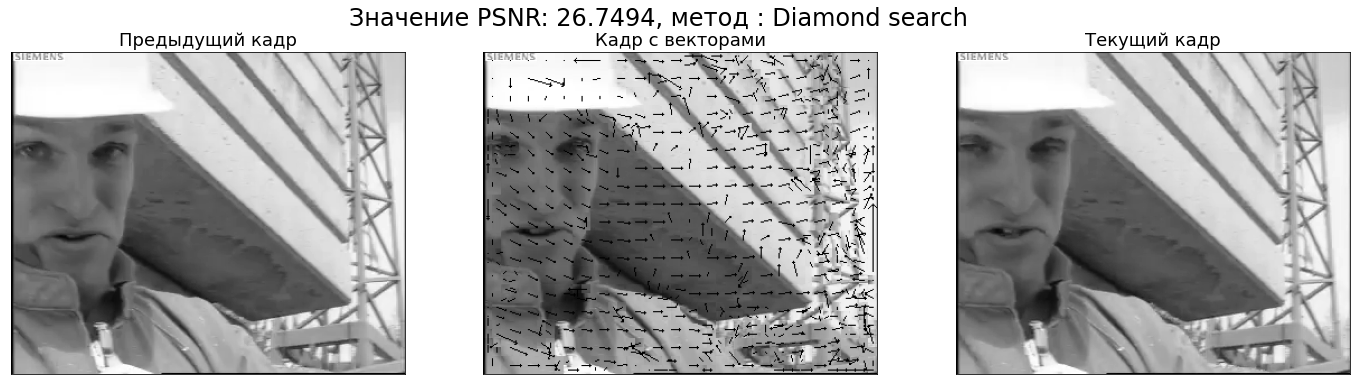

In [39]:
show_frame(frame_idx=180, method=5)

## Susie

### I. Frames with the long motion
29, 35

### II. Frames where candidates can be applied

26, 27

## Foreman

### I. 

### II. 
180

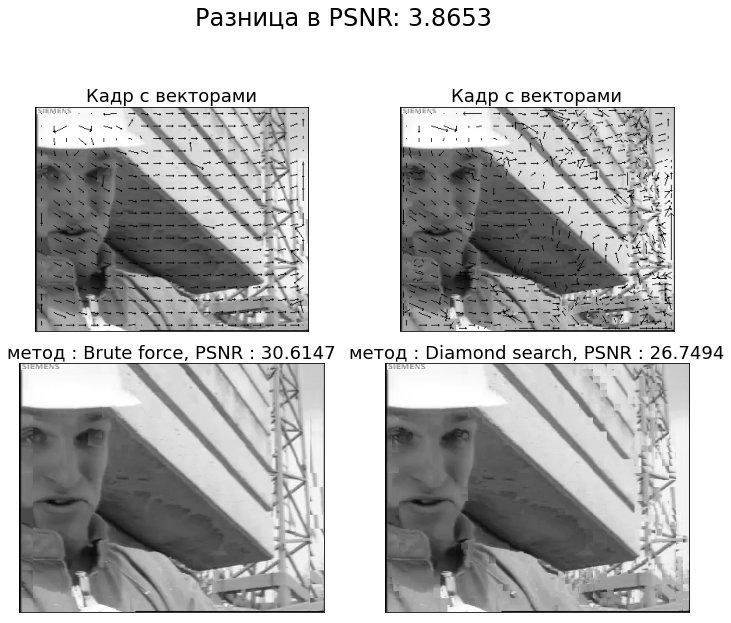

In [40]:
comape_two_methods(frame=180, first_method=0, second_method=5)

In [77]:
def draw_block_error(block_number=0, first_method=0, second_method=5):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
    
    result = get_result(first_method)
    vector_field = result['vector_fields']
    frames = range(0, len(vector_field))
    errors = np.array([vector_field[i][block_number].getError() for i in frames])
    assert not errors[errors < 0].any()
    
    ax[0].plot(frames, errors)
    ax[0].legend(["Squared difference"])
    ax[0].set_title("Method name : {}".format(method_name(first_method)))
    plt.suptitle("Block number : {}".format(block_number), fontsize=24)
    
    result = get_result(second_method)
    vector_field = result['vector_fields']
    frames = range(0, len(vector_field))
    errors = np.array([vector_field[i][block_number].getError() for i in frames])
    assert not errors[errors < 0].any()
    ax[1].plot(frames, errors)
    ax[1].legend(["Squared difference"])
    
    ax[1].set_title("Method name : {}".format(method_name(second_method)))

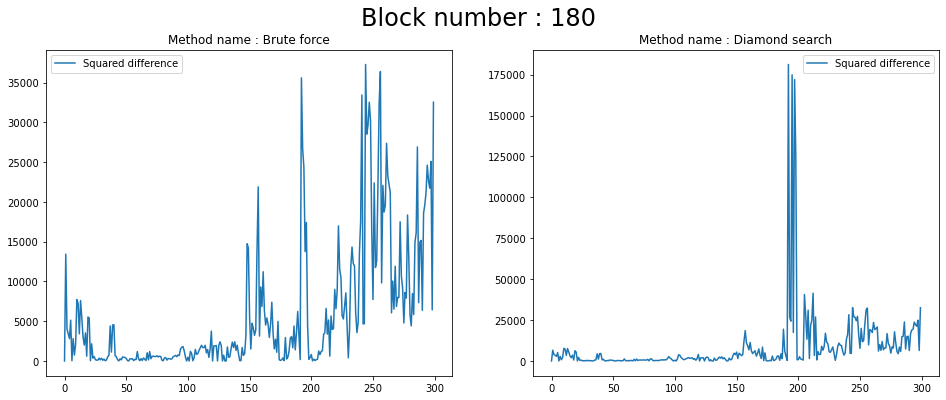

In [78]:
draw_block_error(block_number=180, first_method=0,second_method=5)

In [71]:
def compare_psnr(first_method=0, second_method=5):
    plt.figure(figsize=(12, 6))
    first_result = get_result(first_method)
    second_result = get_result(second_method)
    
    frames = range(0, len(first_result['psnr']))
    first_psnr = np.array([first_result['psnr'][frame] for frame in frames])
    second_psnr = np.array([second_result['psnr'][frame] for frame in frames])
    plt.plot(frames, first_psnr - second_psnr)
    plt.axhline(y=0, linestyle='--', c='red')
    plt.legend(["ΔPSNR"])
    
    plt.xlabel("Frame")
    plt.ylabel("Difference")
    plt.title("Difference in PSNR between {} and {}".format(method_name(first_method), method_name(second_method)))

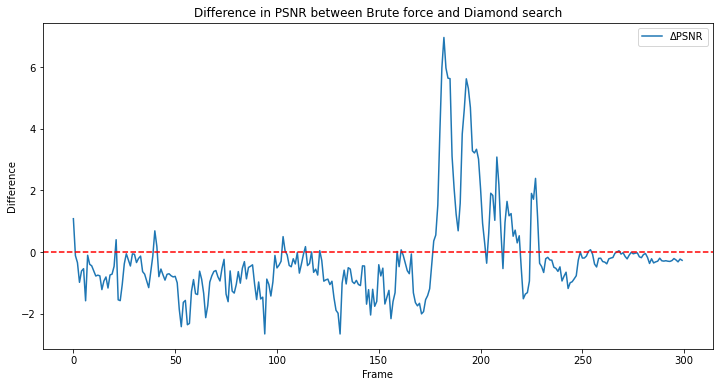

In [72]:
compare_psnr(first_method=0, second_method=5)

## 4. Немного подсказок

* Напишите сначала какой-нибудь базовый алгоритм, который будет вашим бейзлайном. Затем вы будете его постепенно улучшать
* После этого тестируйте каждое улучшение (одно улучшние - один эксперимент), чтобы не добавить в алгоритм то, что на самом деле ухушает алгоритм
* Не стесняйтесь проводить всякие эксперименты вне кода. Например, можно самостоятельно построить пример рельефа ошибки при сопоставлении, смотреть, насколько близки вектора у соседних блоков, исследовать стабильность векторов блоков по времени. Это позволит каждому улучшению работать максимально эффективно.